In [29]:
# =====================================================================
#   CUSTOMER CHURN PREDICTION PROJECT (Simple + Advanced)
# =====================================================================

# --------------------------- PROBLEM STATEMENT ---------------------------
# Many customers leave (churn) from a service company, causing revenue loss.
# The goal is to build a machine learning model that predicts which customers
# are likely to churn so the company can take preventive actions.

# ----------------------------- OBJECTIVES --------------------------------
# 1. Load dataset and perform professional-level preprocessing.
# 2. Handle missing values, outliers, skewed distributions.
# 3. Generate useful engineered features (industry-style).
# 4. Build ML pipeline using ColumnTransformer + Pipelines.
# 5. Train Logistic Regression, Random Forest, and XGBoost (if installed).
# 6. Use RandomizedSearchCV for quick hyperparameter tuning.
# 7. Evaluate using ROC AUC, PR AUC, Confusion Matrix, F1 score.
# 8. Tune decision threshold for better recall/precision.
# 9. Save final trained model for deployment.
# =====================================================================


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

In [23]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve
)
import warnings
warnings.filterwarnings("ignore")


# Optional XGBoost
try:
    import xgboost as xgb
    XGB = True
except:
    XGB = False

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

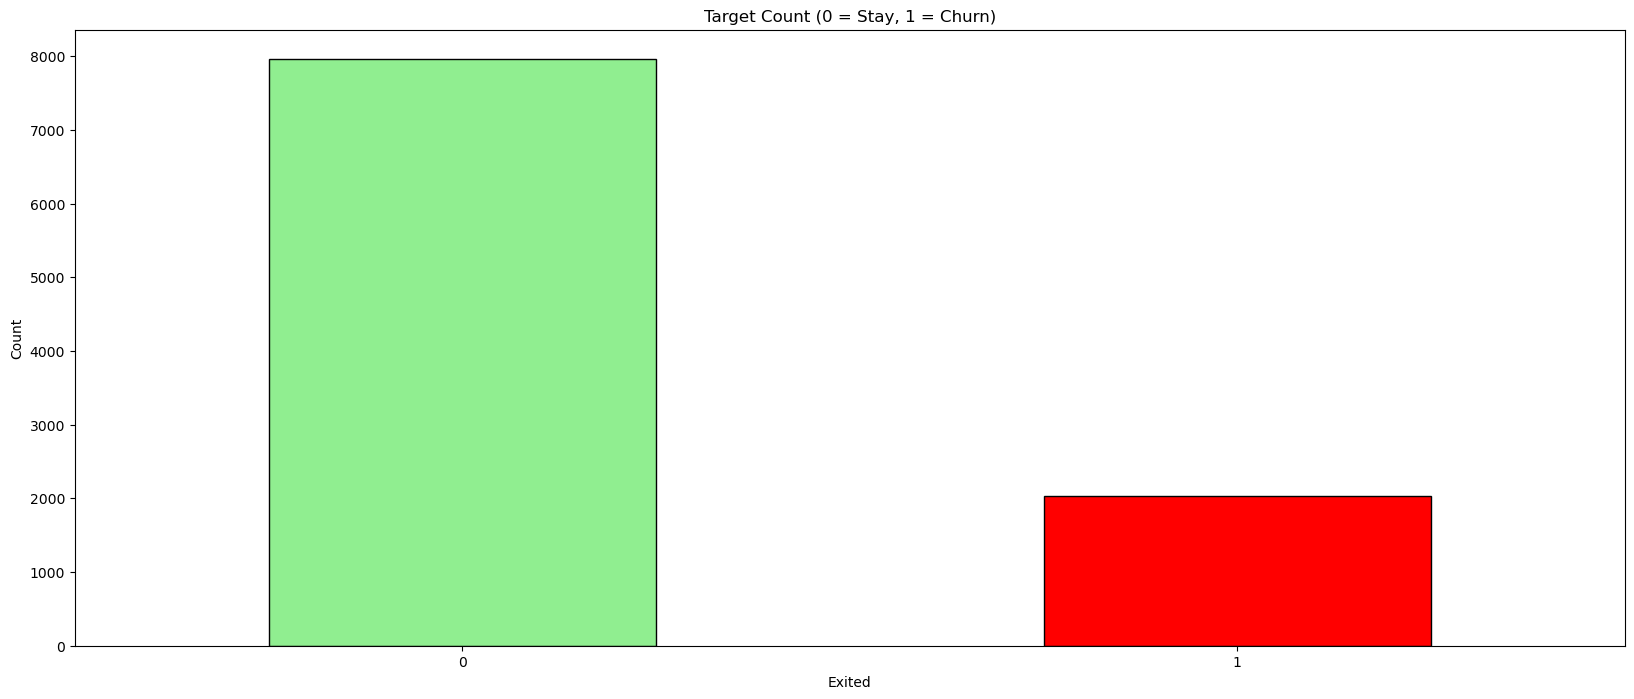

In [24]:
# -----------------------------
# 1) Load data (very simple)
# -----------------------------
df = pd.read_csv(r"C:\Users\rahul\Downloads\Churn_Modelling.csv")
print(df.head())
df = df.drop(columns=["RowNumber","CustomerId","Surname"], errors="ignore")

# -----------------------------
# 2) Quick EDA visualizations
# -----------------------------
plt.figure(figsize=(20,8))
df['Exited'].value_counts().plot(
    kind='bar',
    color=['lightgreen', 'red'],   # simple attractive colors
    edgecolor='black'
)

plt.title('Target Count (0 = Stay, 1 = Churn)')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.show()


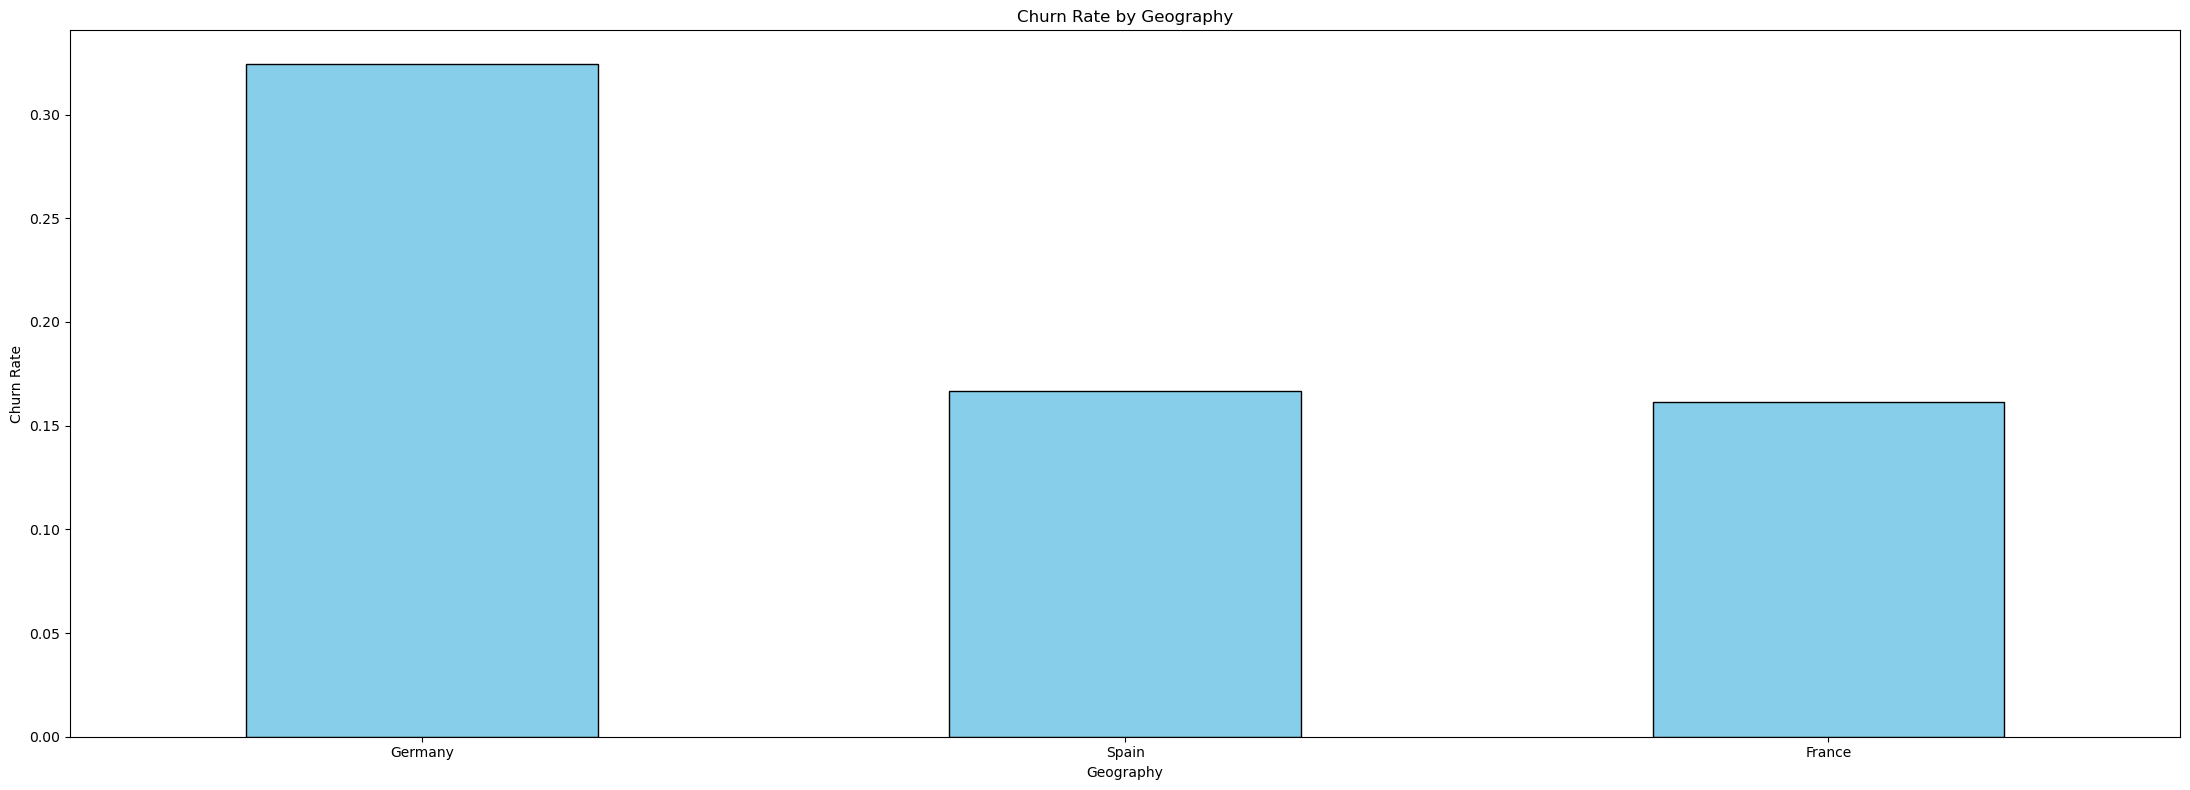

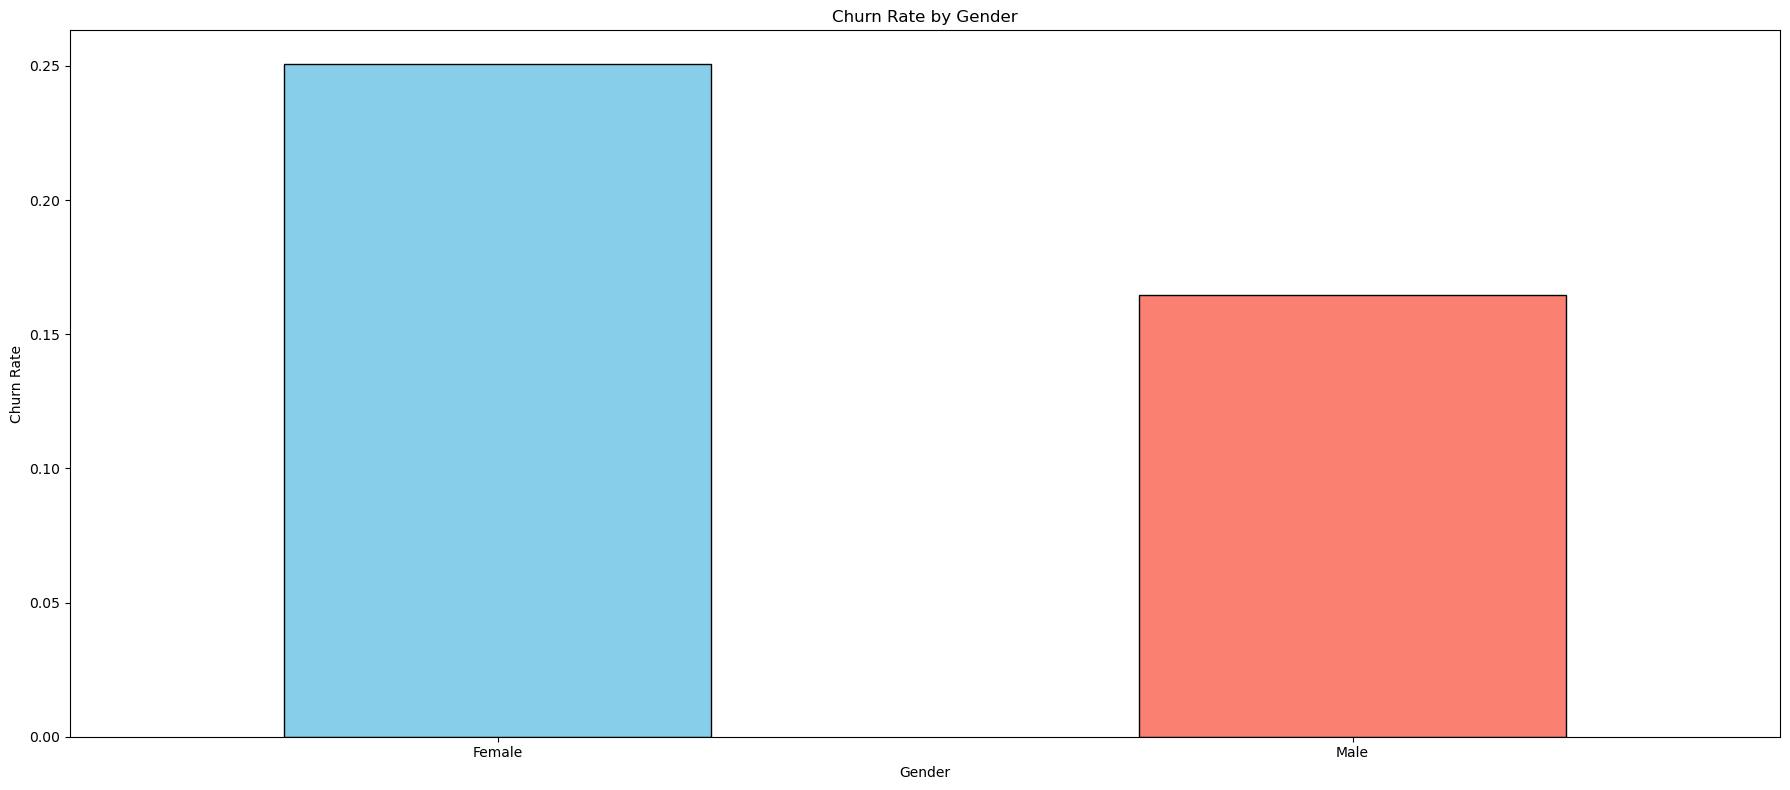

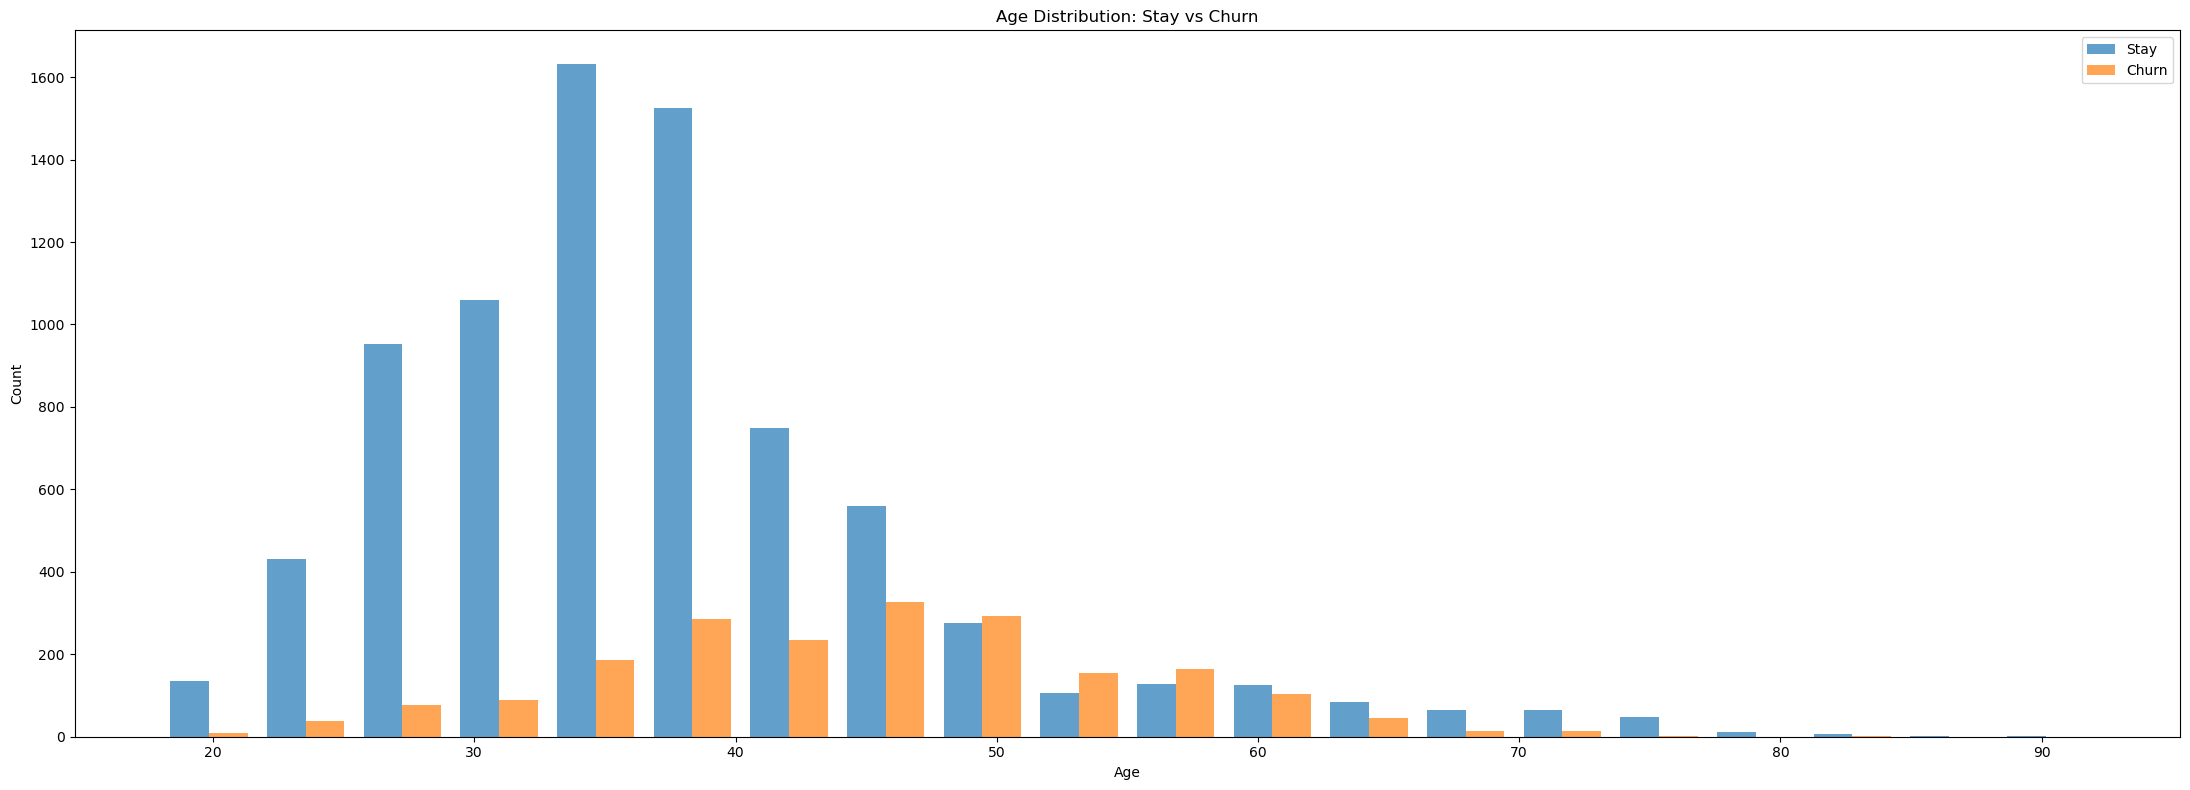

<Figure size 2200x800 with 0 Axes>

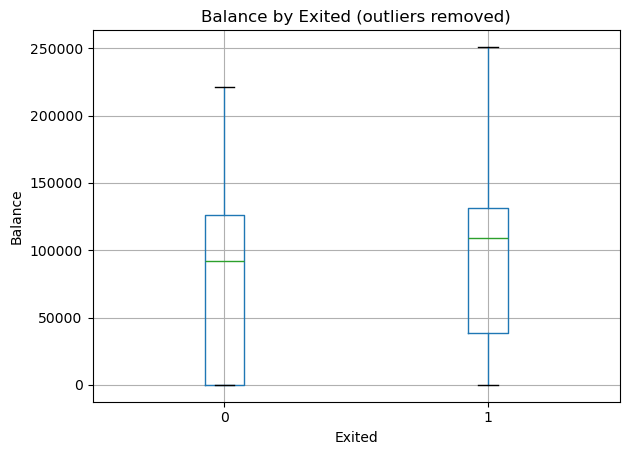

In [25]:
# churn rate by Geography
if 'Geography' in df.columns:
    geo = df.groupby('Geography')['Exited'].mean().sort_values(ascending=False)

    plt.figure(figsize=(22,8))
    geo.plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title('Churn Rate by Geography')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

# churn rate by Gender
if 'Gender' in df.columns:
    gen = df.groupby('Gender')['Exited'].mean().sort_values(ascending=False)

    plt.figure(figsize=(18,8))
    gen.plot(kind='bar', color=['skyblue','salmon'], edgecolor='black')

    plt.title('Churn Rate by Gender')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Age distribution split by churn
plt.figure(figsize=(22,8))
plt.hist(
    [df[df['Exited']==0]['Age'], df[df['Exited']==1]['Age']],
    bins=20,
    label=['Stay','Churn'],
    alpha=0.7
)

plt.title('Age Distribution: Stay vs Churn')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


# Balance distribution (boxplot) by Exited
plt.figure(figsize=(22,8))
df.boxplot(column='Balance', by='Exited', showfliers=False)

plt.title('Balance by Exited (outliers removed)')
plt.suptitle('')
plt.xlabel('Exited')
plt.ylabel('Balance')
plt.tight_layout()
plt.show()



In [26]:
# -----------------------------
# 3) Preprocessing & feature engineering (same simple style)
# -----------------------------
def cap_iqr(s):
    q1 = s.quantile(0.25); q3 = s.quantile(0.75); iqr = q3 - q1
    return s.clip(q1 - 1.5*iqr, q3 + 1.5*iqr)

num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_cols = [c for c in num_cols if c != 'Exited']
for c in num_cols:
    df[c] = cap_iqr(df[c])

# feature engineering (simple & useful)
df['Balance_per_Product'] = df['Balance'] / (df['NumOfProducts'].replace(0,1))
df['High_Balance'] = (df['Balance'] > df['Balance'].median()).astype(int)
df['Log_Balance'] = np.log1p(df['Balance'])
df['Log_Salary'] = np.log1p(df['EstimatedSalary'])

# drop correlated if any (simple threshold)
numeric_now = df.select_dtypes(include=['number']).columns.tolist()
numeric_now = [c for c in numeric_now if c != 'Exited']
corr_mat = df[numeric_now].corr().abs()
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(bool))
drop = [col for col in upper.columns if any(upper[col] > 0.95)]
if drop:
    df = df.drop(columns=drop)
    print("Dropped highly correlated:", drop)


In [27]:
# -----------------------------
# 4) Prepare X, y and split
# -----------------------------
X = df.drop('Exited', axis=1)
y = df['Exited'].astype(int)

numeric = X.select_dtypes(include=['number']).columns.tolist()
categorical = X.select_dtypes(include=['object','category']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [28]:
# -----------------------------
# 5) Preprocessor + Models
# -----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scale', RobustScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_pipe, numeric), ('cat', cat_pipe, categorical)])

models = {
    'logistic': LogisticRegression(max_iter=2000),
    'rf': RandomForestClassifier()
}
if XGB:
    models['xgb'] = xgb.XGBClassifier(eval_metric='logloss')

params = {
    'logistic': {'model__C': [0.1, 1, 10]},
    'rf': {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None]},
    'xgb': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 6]}
}


In [29]:
# -----------------------------
# 5) Preprocessor + Models
# -----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scale', RobustScaler())])
cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', num_pipe, numeric), ('cat', cat_pipe, categorical)])

models = {
    'logistic': LogisticRegression(max_iter=2000),
    'rf': RandomForestClassifier()
}
if XGB:
    models['xgb'] = xgb.XGBClassifier(eval_metric='logloss')

params = {
    'logistic': {'model__C': [0.1, 1, 10]},
    'rf': {'model__n_estimators': [100, 200], 'model__max_depth': [5, 10, None]},
    'xgb': {'model__n_estimators': [100, 200], 'model__max_depth': [3, 6]}
}


In [30]:

# -----------------------------
# 6) Training & selection (quick tuning)
# -----------------------------
best_model = None; best_score = -1; best_name = None
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTraining: {name}")
    pipe = Pipeline([('prep', preprocessor), ('model', model)])
    search = RandomizedSearchCV(pipe, params.get(name, {}), n_iter=5, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
    search.fit(X_train, y_train)
    print("Best val ROC AUC:", search.best_score_)
    if search.best_score_ > best_score:
        best_score = search.best_score_; best_model = search.best_estimator_; best_name = name

print(f"\nSelected best model: {best_name} (val ROC AUC={best_score:.4f})")


Training: logistic
Best val ROC AUC: 0.7719703495296001

Training: rf
Best val ROC AUC: 0.8614469470582625

Training: xgb
Best val ROC AUC: 0.857732265965931

Selected best model: rf (val ROC AUC=0.8614)


In [31]:
# -----------------------------
# 7) Evaluate & plots (ROC, PR)
# -----------------------------
y_proba = best_model.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print("\nTest metrics:")
print("ROC AUC:", round(roc,4), "PR AUC:", round(pr_auc,4))
print("Accuracy:", round(accuracy_score(y_test, y_pred),4))
print("Precision:", round(precision_score(y_test, y_pred),4))
print("Recall:", round(recall_score(y_test, y_pred),4))
print("F1:", round(f1_score(y_test, y_pred),4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Test metrics:
ROC AUC: 0.8616 PR AUC: 0.7074
Accuracy: 0.866
Precision: 0.8233
Recall: 0.4349
F1: 0.5691

Confusion Matrix:
 [[1555   38]
 [ 230  177]]


 98%|===================| 985/1000 [00:25<00:00]        

SHAP values/features mismatch (features): (500, 2) vs (500, 17) — truncating to 2 features.

Global SHAP summary (bar + beeswarm):


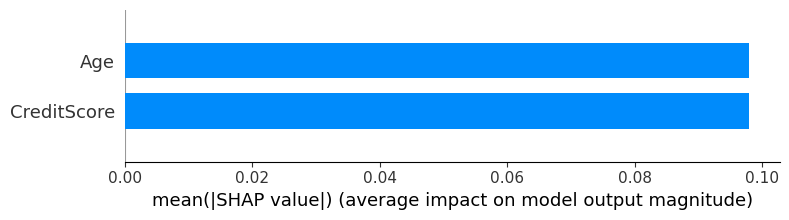

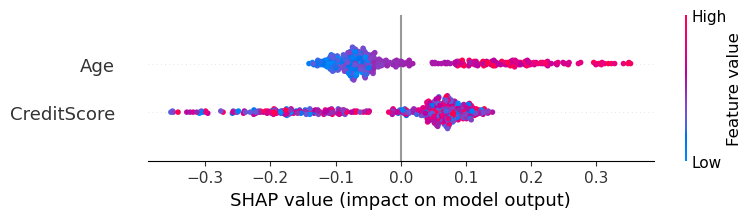


Local SHAP explanation for test index (highest churn prob): 248
Could not render waterfall/force plot for local explanation: In v0.20, force plot now requires the base value as the first parameter! Try shap.plots.force(explainer.expected_value, shap_values) or for multi-output models try shap.plots.force(explainer.expected_value[0], shap_values[..., 0]).

Dependence plot for top feature: Age


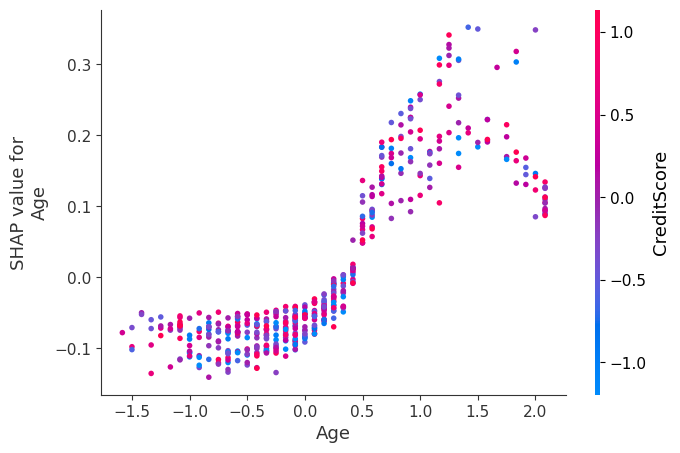

Saved SHAP summary CSV: shap_feature_importance.csv


In [32]:
# ---------------------------
# Robust SHAP explainability (fixed)
# Paste this AFTER joblib.dump(...) & save print
# Requires: pip install shap
# ---------------------------


try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False
    print("shap not installed. Install with: pip install shap. Skipping SHAP.")
    
if SHAP_AVAILABLE:
    # 1) get preprocessor and model from pipeline
    try:
        preproc = best_model.named_steps.get('prep') or best_model.named_steps.get('preprocessor')
        model_obj = best_model.named_steps['model']
    except Exception as e:
        print("ERROR: Could not extract pipeline steps 'prep'/'model'.", e)
        SHAP_AVAILABLE = False

if SHAP_AVAILABLE:
    # 2) get feature names after preprocessing (best-effort)
    numeric_cols = X_test.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_test.select_dtypes(include=['object','category']).columns.tolist()
    feat_names = []
    try:
        cat_tr = preproc.named_transformers_.get('cat', None)
        if cat_tr is not None and hasattr(cat_tr, "named_steps") and 'ohe' in cat_tr.named_steps:
            ohe = cat_tr.named_steps['ohe']
            ohe_names = list(ohe.get_feature_names_out(categorical_cols))
        else:
            ohe_names = categorical_cols
        feat_names = numeric_cols + ohe_names
    except Exception:
        feat_names = numeric_cols + categorical_cols

    # 3) prepare preprocessed arrays (train background, test sample)
    X_train_trans = preproc.transform(X_train.sample(n=min(200, len(X_train)), random_state=42))
    X_test_sample = X_test.sample(n=min(500, len(X_test)), random_state=42)
    X_test_trans = preproc.transform(X_test_sample)

    # 4) compute SHAP values with robust branching
    vals = None   # will hold final numpy array (n_samples, n_features)
    base_values = None
    explainer = None

    # prefer shap.Explainer (new API) — try/except because it can fail for some models
    try:
        explainer = shap.Explainer(model_obj, X_train_trans)
        svals = explainer(X_test_trans)   # returns Explanation object in modern shap
        # svals.values shape might be (n_samples, n_features) or (n_samples, n_classes, n_features)
        if hasattr(svals, "values"):
            vals = np.array(svals.values)
            base_values = getattr(svals, "base_values", None)
            data_for_plots = svals.data if hasattr(svals, "data") else X_test_trans
        else:
            vals = np.array(svals)
            data_for_plots = X_test_trans
    except Exception as e_new:
        # fallback to TreeExplainer (good for tree models)
        try:
            explainer = shap.TreeExplainer(model_obj)
            svals = explainer.shap_values(X_test_trans)
            # shap.TreeExplainer often returns list (per class) or array
            if isinstance(svals, list):
                # binary classification: pick class 1 explanations if present
                if len(svals) > 1:
                    vals = np.array(svals[1])
                else:
                    vals = np.array(svals[0])
            else:
                vals = np.array(svals)
            base_values = explainer.expected_value
            data_for_plots = X_test_trans
        except Exception as e_tree:
            print("SHAP both explainer attempts failed:", e_new, e_tree)
            vals = None

    # 5) normalize vals -> ensure shape (n_samples, n_features)
    if vals is None:
        print("SHAP values could not be computed. Skipping SHAP plots.")
    else:
        # sometimes vals shape is (n_samples, n_classes, n_features)
        if vals.ndim == 3:
            # prefer positive class index 1 if exists
            if vals.shape[1] > 1:
                vals = vals[:, 1, :]
            else:
                vals = vals[:, 0, :]

        # align number of features between vals and transformed data
        n_feats_vals = vals.shape[1]
        n_feats_data = X_test_trans.shape[1]
        if n_feats_vals != n_feats_data:
            # try re-transform and recompute feature names from transformer
            try:
                data_for_plots = preproc.transform(X_test_sample)
                n_feats_data = data_for_plots.shape[1]
            except Exception:
                pass
            # if still mismatch, truncate to min dimension (best-effort)
            if n_feats_vals != n_feats_data:
                m = min(n_feats_vals, n_feats_data)
                print(f"SHAP values/features mismatch (features): {vals.shape} vs {data_for_plots.shape} — truncating to {m} features.")
                vals = vals[:, :m]
                data_for_plots = data_for_plots[:, :m]
                feat_names = feat_names[:m]

        # convert data_for_plots to DataFrame for nicer labels
        try:
            df_shap_X = pd.DataFrame(data_for_plots, columns=feat_names)
        except Exception:
            df_shap_X = pd.DataFrame(data_for_plots)

        # ----- Global plots (bar + beeswarm) -----
        try:
            print("\nGlobal SHAP summary (bar + beeswarm):")
            shap.summary_plot(vals, df_shap_X, feature_names=feat_names, plot_type="bar", show=True)
            shap.summary_plot(vals, df_shap_X, feature_names=feat_names, show=True)
        except Exception as e:
            print("Failed to create SHAP global plots:", e)

        # ----- Local explanation (waterfall/force) for highest-risk test row -----
        try:
            # find highest churn prob in full test set (use y_proba if present)
            probs_full = y_proba if 'y_proba' in globals() else best_model.predict_proba(X_test)[:,1]
            hi_idx = int(np.argmax(probs_full))
            print(f"\nLocal SHAP explanation for test index (highest churn prob): {hi_idx}")

            # transform that single row
            x_single = X_test.iloc[[hi_idx]]
            x_single_trans = preproc.transform(x_single)

            # compute shap values for single instance using explainer
            try:
                sv_single = explainer(x_single_trans)
                # attempt waterfall (modern shap)
                try:
                    shap.plots.waterfall(sv_single[0], max_display=12, show=True)
                except Exception:
                    # fallback: force plot with correct expected_value argument
                    ev = sv_single.base_values[0] if hasattr(sv_single, "base_values") else None
                    vals_single = sv_single.values[0] if hasattr(sv_single, "values") else np.array(sv_single)[0]
                    try:
                        shap.force_plot(ev, vals_single, feature_names=feat_names, matplotlib=True)
                    except Exception as e_fp:
                        print("Could not render waterfall/force plot for local explanation:", e_fp)
            except Exception as e_local:
                # if explainer(...) failed, try using TreeExplainer directly for single instance
                try:
                    te = shap.TreeExplainer(model_obj)
                    svals_single = te.shap_values(x_single_trans)
                    if isinstance(svals_single, list) and len(svals_single) > 1:
                        single_vals = np.array(svals_single[1])[0]
                        ev = te.expected_value[1] if hasattr(te.expected_value, "__len__") else te.expected_value
                    else:
                        single_vals = np.array(svals_single)[0]
                        ev = te.expected_value
                    shap.force_plot(ev, single_vals, feature_names=feat_names, matplotlib=True)
                except Exception as e2:
                    print("Local SHAP explanation failed:", e_local, e2)
        except Exception as e:
            print("Local SHAP step overall failed:", e)

        # ----- Dependence plot for top feature -----
        try:
            mean_abs = np.mean(np.abs(vals), axis=0)
            top_idx = int(np.argmax(mean_abs))
            top_feat = feat_names[top_idx]
            print("\nDependence plot for top feature:", top_feat)
            shap.dependence_plot(top_feat, vals, df_shap_X, show=True)
        except Exception as e:
            print("Dependence plot failed:", e)

        # ----- Save SHAP importances to CSV -----
        try:
            mean_abs_shap = np.mean(np.abs(vals), axis=0)
            shap_df = pd.DataFrame({"feature": feat_names[:len(mean_abs_shap)], "mean_abs_shap": mean_abs_shap})
            shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
            shap_df.to_csv("shap_feature_importance.csv", index=False)
            print("Saved SHAP summary CSV: shap_feature_importance.csv")
        except Exception as e:
            print("Saving SHAP CSV failed:", e)


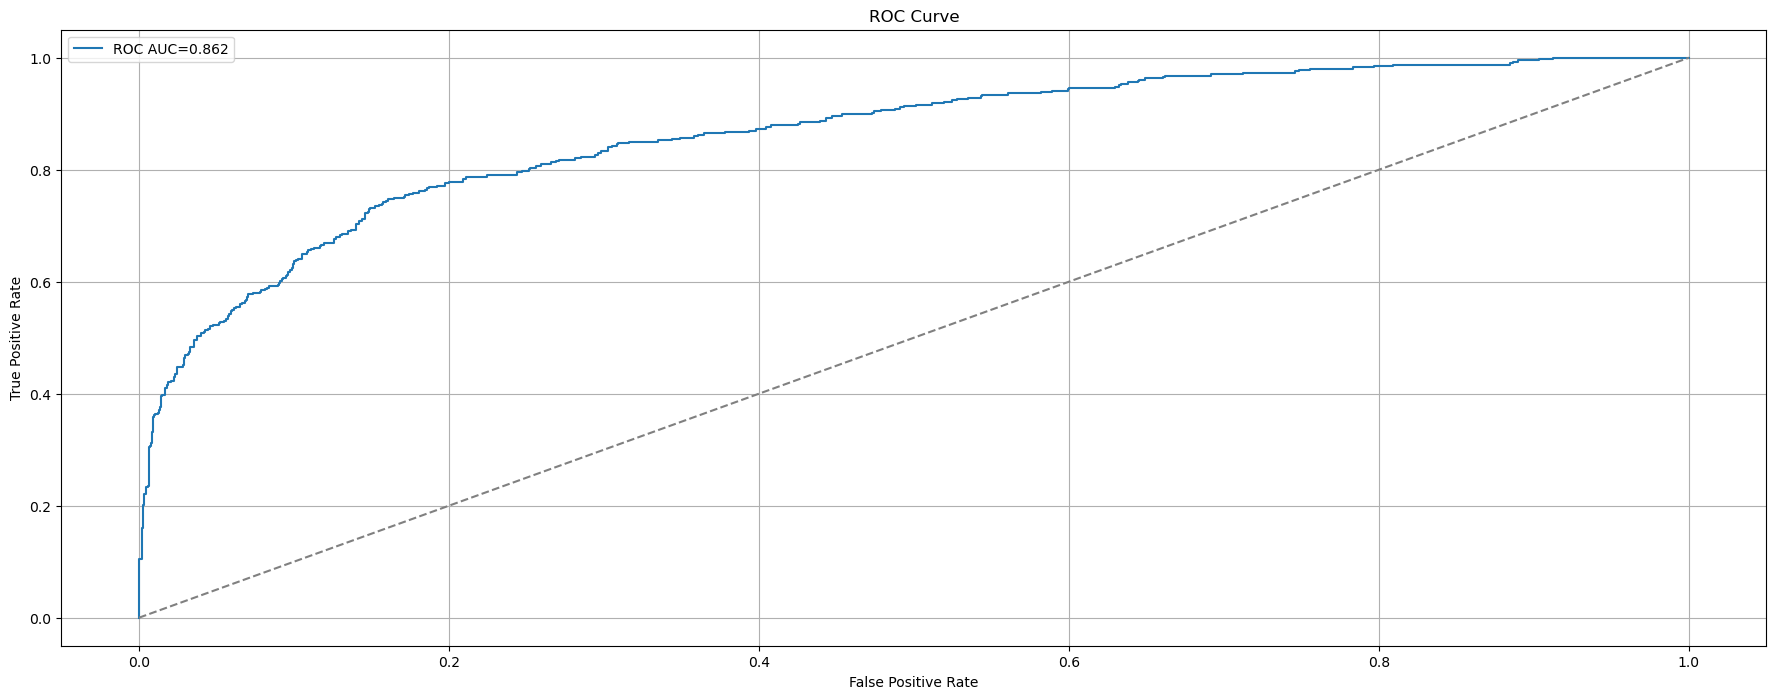

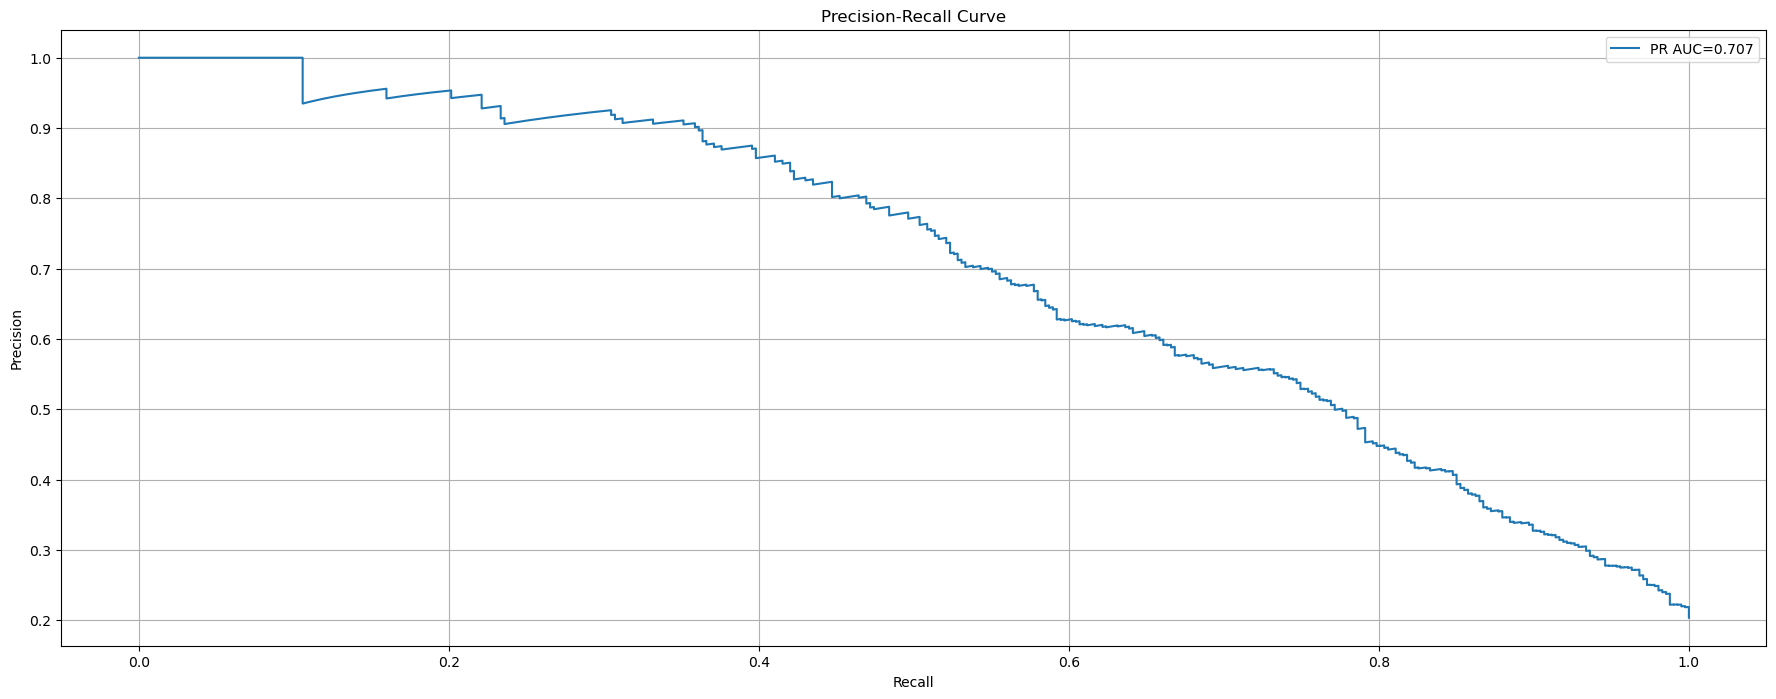

In [33]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(22,8))
plt.plot(fpr, tpr, label=f'ROC AUC={roc:.3f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.grid(True); plt.show()

# PR Curve
plt.figure(figsize=(22,8))
plt.plot(recall, precision, label=f'PR AUC={pr_auc:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve'); plt.legend(); plt.grid(True); plt.show()

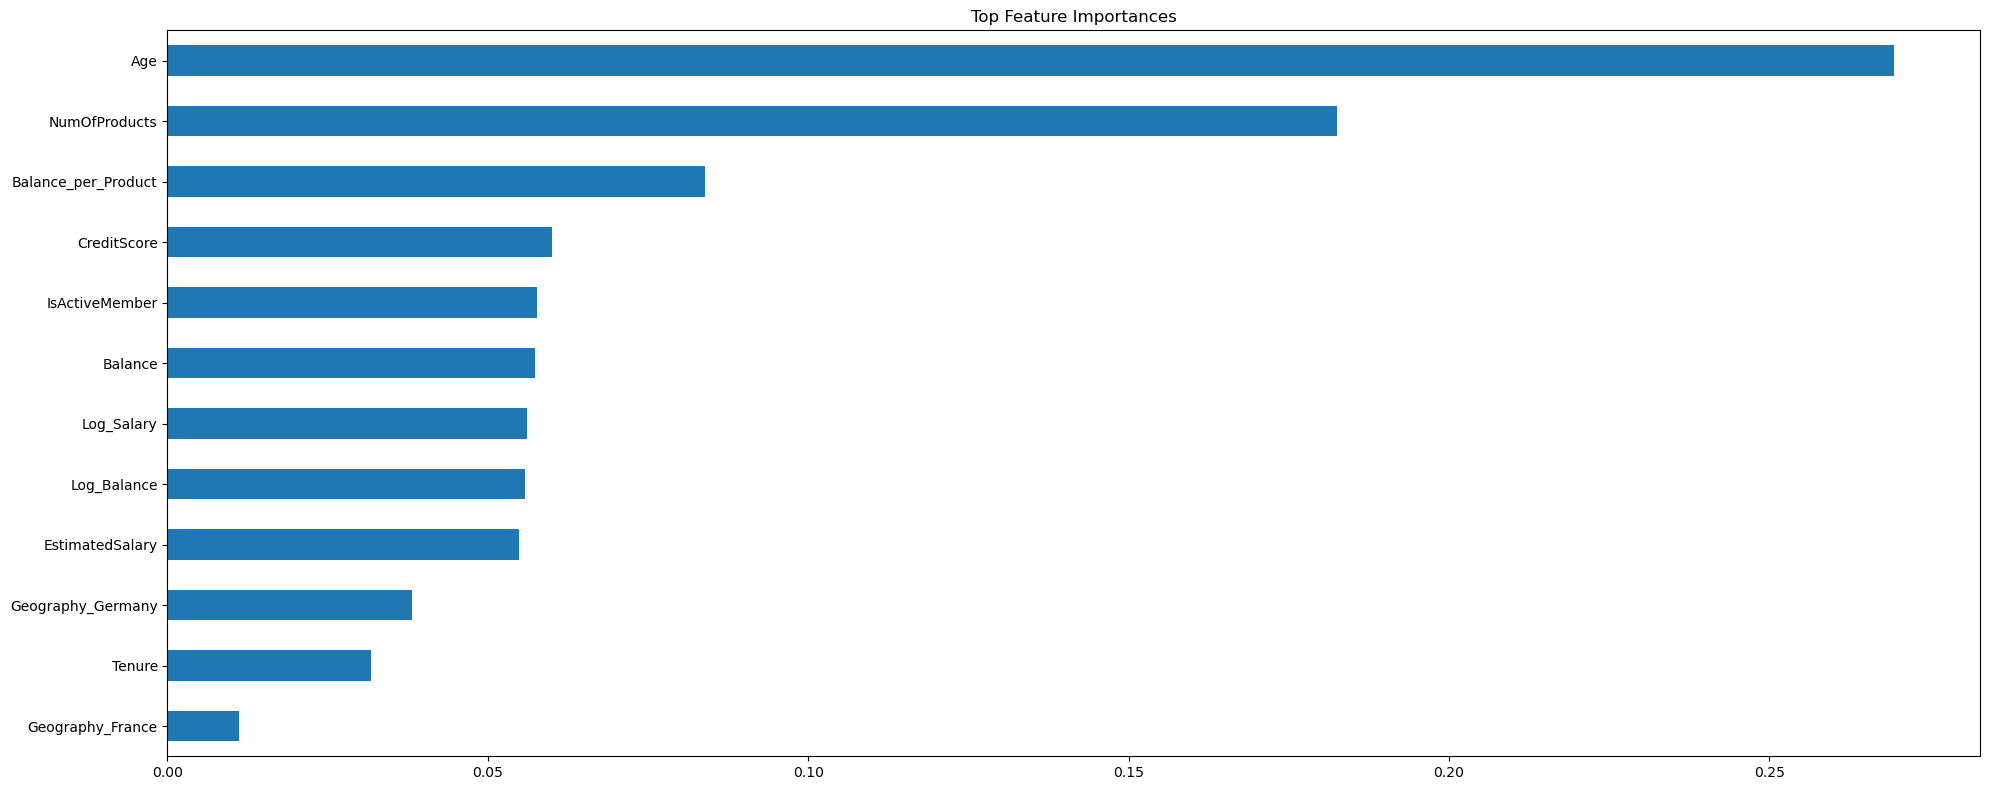

In [34]:
# -----------------------------
# 8) Feature importance (if tree)
# -----------------------------
try:
    model_obj = best_model.named_steps['model']
    if hasattr(model_obj, 'feature_importances_'):
        # get feature names after preprocess
        pre = best_model.named_steps['prep']
        # numeric names
        num_names = numeric
        # onehot feature names
        ohe = pre.named_transformers_['cat'].named_steps['ohe']
        try:
            cat_names = list(ohe.get_feature_names_out(categorical))
        except:
            cat_names = categorical
        feat_names = num_names + cat_names
        importances = pd.Series(model_obj.feature_importances_, index=feat_names).sort_values(ascending=False)
        plt.figure(figsize=(20,8))
        importances.head(12).plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.title('Top Feature Importances')
        plt.tight_layout(); plt.show()
except Exception as e:
    print("Feature importance not available:", e)

In [35]:

# -----------------------------
# 9) Threshold tuning (find best F1 threshold)
# -----------------------------
thresholds = np.linspace(0,1,101)
f1s = [f1_score(y_test, (y_proba >= t).astype(int)) for t in thresholds]
best_t = thresholds[int(np.argmax(f1s))]
print("Best threshold by F1:", round(best_t,2))


Best threshold by F1: 0.25


In [36]:
# show metrics at best threshold
y_pred_best = (y_proba >= best_t).astype(int)
print("Metrics at best threshold:")
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1:", f1_score(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# -----------------------------
# 10) Save final model
# -----------------------------
joblib.dump(best_model, 'churn_best_model_with_plots.joblib')
print("Saved model: churn_best_model_with_plots.joblib")



Metrics at best threshold:
Precision: 0.5570093457943925
Recall: 0.7321867321867321
F1: 0.6326963906581741
Confusion Matrix:
 [[1356  237]
 [ 109  298]]
Saved model: churn_best_model_with_plots.joblib


XGBoost trained for SHAP. Best val ROC AUC: 0.8634
Saved XGBoost (for SHAP) as xgb_for_shap.joblib

SHAP global summary (bar + beeswarm):


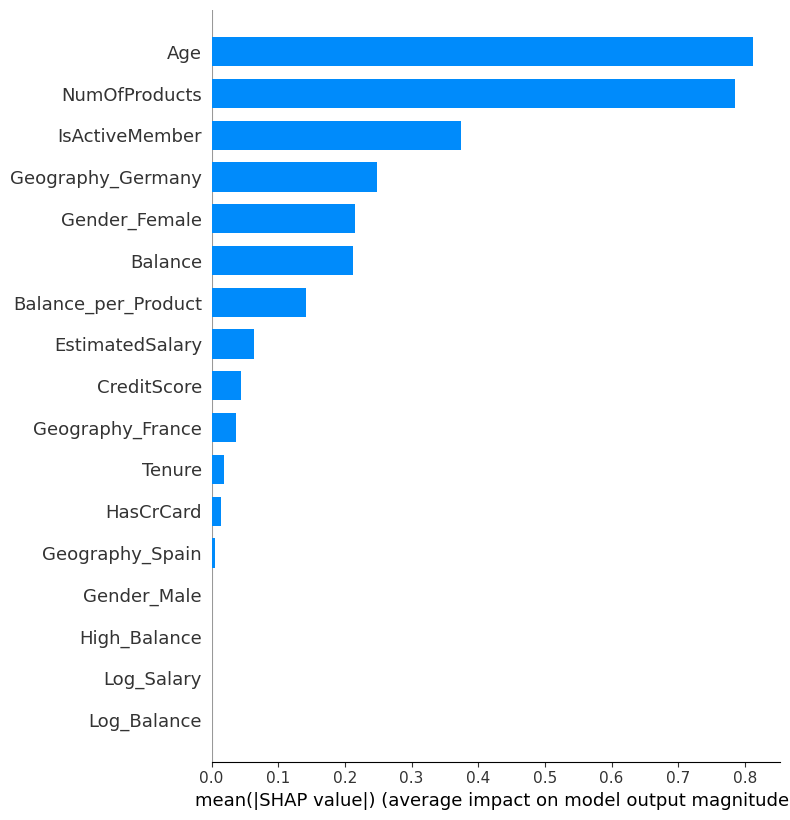

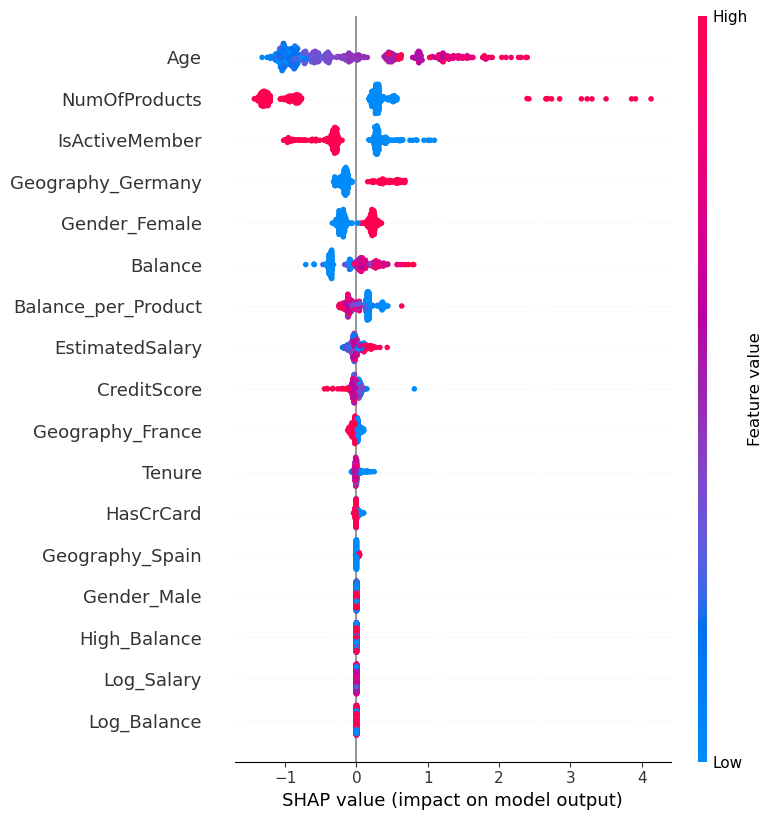

Top SHAP feature: Age


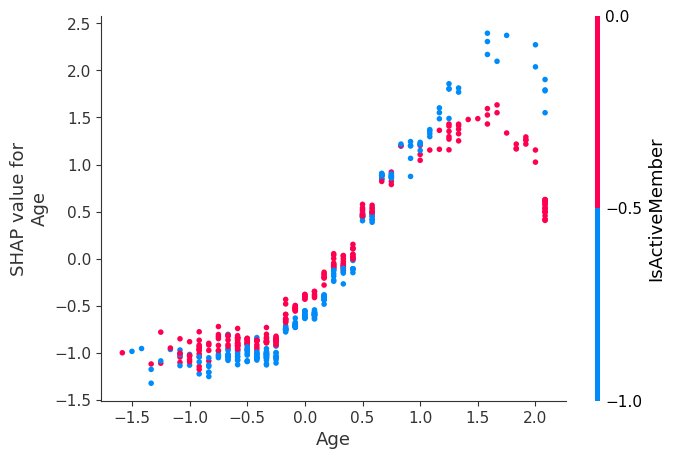

Highest-risk test index not in SHAP sample. Re-run with larger sample or compute SHAP on that single instance.
Saved SHAP CSV: xgb_shap_feat_importance.csv


In [37]:
# ---------------------------
# ADD-ON: Train a short XGBoost on preprocessed arrays + SHAP (minimal, non-invasive)
# Paste this block RIGHT AFTER you saved your main pipeline (joblib.dump(...))
# ---------------------------

import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# 1) Requirements check
try:
    import xgboost as xgb
except Exception:
    print("xgboost not installed. Install with: pip install xgboost")
    raise

try:
    import shap
except Exception:
    print("shap not installed. Install with: pip install shap")
    raise

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score, confusion_matrix, classification_report

# 2) Get preprocessor from your existing pipeline (works if step named 'prep' or 'preprocessor')
preproc = None
if isinstance(best_model, object):
    preproc = getattr(best_model.named_steps, 'get', None) and (best_model.named_steps.get('prep') or best_model.named_steps.get('preprocessor'))
if preproc is None:
    # try both keys robustly
    try:
        preproc = best_model.named_steps['prep']
    except:
        preproc = best_model.named_steps.get('preprocessor', None)

if preproc is None:
    raise RuntimeError("Cannot find preprocessor step in best_model pipeline. Ensure your pipeline has 'prep' or 'preprocessor' step.")

# 3) Transform train & test arrays (do NOT change X_train/X_test)
X_train_trans = preproc.transform(X_train)
X_test_trans  = preproc.transform(X_test)

# 4) Build & quick-tune a lightweight XGBoost (only for explainability)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
param_dist = {'n_estimators':[100,200], 'max_depth':[3,6], 'learning_rate':[0.05,0.1]}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
search = RandomizedSearchCV(xgb_clf, param_distributions=param_dist, n_iter=6, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42, verbose=0)
search.fit(X_train_trans, y_train)
best_xgb = search.best_estimator_

print("XGBoost trained for SHAP. Best val ROC AUC:", round(search.best_score_,4))
joblib.dump(best_xgb, "xgb_for_shap.joblib")
print("Saved XGBoost (for SHAP) as xgb_for_shap.joblib")

# 5) SHAP explainability (TreeExplainer on transformed arrays)
explainer = shap.TreeExplainer(best_xgb)
sample_n = min(500, X_test_trans.shape[0])
X_shap = X_test_trans[:sample_n]
shap_values = explainer.shap_values(X_shap)

# normalize into 2D (n_samples, n_features)
if isinstance(shap_values, list):
    # binary classification: use positive-class shap values if present
    sv = np.array(shap_values[1]) if len(shap_values) > 1 else np.array(shap_values[0])
else:
    sv = np.array(shap_values)
if sv.ndim == 3:  # sometimes (n_samples, n_classes, n_features)
    sv = sv[:, 1, :]

# get feature names from preprocessor (best-effort)
feat_names = []
try:
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()
    cat_tr = preproc.named_transformers_.get('cat', None)
    if cat_tr is not None and hasattr(cat_tr, 'named_steps') and 'ohe' in cat_tr.named_steps:
        ohe = cat_tr.named_steps['ohe']
        cat_names = list(ohe.get_feature_names_out(categorical_cols))
    else:
        cat_names = categorical_cols
    feat_names = numeric_cols + cat_names
except Exception:
    # fallback: simple numeric indices
    feat_names = [f"f{i}" for i in range(sv.shape[1])]

# align shapes (truncate if necessary — safe for visualization)
if sv.shape[1] != X_shap.shape[1]:
    m = min(sv.shape[1], X_shap.shape[1])
    print(f"SHAP/X mismatch: truncating to {m} features for plotting.")
    sv = sv[:, :m]
    X_shap = X_shap[:, :m]
    feat_names = feat_names[:m]

# 6) Global SHAP plots (bar + beeswarm)
print("\nSHAP global summary (bar + beeswarm):")
shap.summary_plot(sv, pd.DataFrame(X_shap, columns=feat_names), plot_type="bar", show=True)
shap.summary_plot(sv, pd.DataFrame(X_shap, columns=feat_names), show=True)

# 7) Dependence plot for top feature
mean_abs = np.mean(np.abs(sv), axis=0)
top_idx = int(np.argmax(mean_abs))
top_feat = feat_names[top_idx]
print("Top SHAP feature:", top_feat)
try:
    shap.dependence_plot(top_feat, sv, pd.DataFrame(X_shap, columns=feat_names), show=True)
except Exception as e:
    print("Dependence plot failed:", e)

# 8) Local explanation (waterfall/force) for the highest-risk customer (test)
probs_full = best_xgb.predict_proba(X_test_trans)[:,1]
hi_idx = int(np.argmax(probs_full))  # index in X_test_trans
if hi_idx < sample_n:
    rel_idx = hi_idx
    try:
        # create Explanation object for waterfall (works for shap >=0.40)
        try:
            expl = shap.Explanation(values=sv[rel_idx], base_values=explainer.expected_value if not isinstance(explainer.expected_value, np.ndarray) else (explainer.expected_value[1] if len(explainer.expected_value)>1 else explainer.expected_value), data=X_shap[rel_idx], feature_names=feat_names)
            shap.plots.waterfall(expl, max_display=12, show=True)
        except Exception:
            ev = explainer.expected_value if not isinstance(explainer.expected_value, np.ndarray) else (explainer.expected_value[1] if len(explainer.expected_value)>1 else explainer.expected_value)
            shap.force_plot(ev, sv[rel_idx], pd.DataFrame([X_shap[rel_idx]], columns=feat_names), matplotlib=True)
    except Exception as e:
        print("Local SHAP plot failed:", e)
else:
    print("Highest-risk test index not in SHAP sample. Re-run with larger sample or compute SHAP on that single instance.")

# 9) Save SHAP importances CSV
mean_abs_shap = np.mean(np.abs(sv), axis=0)
shap_df = pd.DataFrame({"feature": feat_names[:len(mean_abs_shap)], "mean_abs_shap": mean_abs_shap})
shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
shap_df.to_csv("xgb_shap_feat_importance.csv", index=False)
print("Saved SHAP CSV: xgb_shap_feat_importance.csv")

# ---------------------------
# Done. This was intentionally non-invasive:
# - It DOES NOT replace your main model.
# - It trains a separate XGBoost only for SHAP explainability on preprocessed arrays.
# ---------------------------


In [38]:
# ================================
# CUSTOMER-LEVEL CHURN PREDICTIONS
# ================================

X_test_copy = X_test.copy()
X_test_copy["Churn_Probability"] = y_proba
X_test_copy["Predicted_Churn"] = (y_proba >= best_t).astype(int)

# Show the first 10 customers predicted to churn
churn_customers = X_test_copy[X_test_copy["Predicted_Churn"] == 1]
print("\nSample churn customers:")
display(churn_customers.head(10))



Sample churn customers:


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Balance_per_Product,High_Balance,Log_Balance,Log_Salary,Churn_Probability,Predicted_Churn
845,505,France,Male,49,7,80001.23,1.0,0,0,135180.11,80001.230,0,11.289810,11.814371,0.573095,1
7068,699,Germany,Female,54,3,111009.32,1.0,1,1,155905.79,111009.320,1,11.617378,11.957014,0.621164,1
5219,625,France,Female,38,7,0.00,1.0,1,0,164804.02,0.000,0,0.000000,12.012518,0.255970,1
2350,617,Germany,Female,58,3,119024.75,2.0,1,0,35199.24,59512.375,1,11.687095,10.468808,0.587105,1
4509,572,Germany,Female,35,1,139979.07,1.0,1,0,185662.84,139979.070,1,11.849255,12.131693,0.292984,1
4799,551,France,Male,52,1,0.00,1.0,0,0,63584.55,0.000,0,0.000000,11.060142,0.591356,1
6984,588,France,Male,44,8,154409.74,1.0,1,0,49324.03,154409.740,1,11.947371,10.806187,0.311860,1
3982,614,France,Male,46,4,0.00,1.0,1,0,74379.57,0.000,0,0.000000,11.216950,0.469707,1
6041,775,France,Male,45,8,0.00,1.0,1,0,130376.68,0.000,0,0.000000,11.778191,0.537103,1
1195,676,France,Female,43,2,0.00,1.0,1,1,55119.53,0.000,0,0.000000,10.917278,0.349694,1


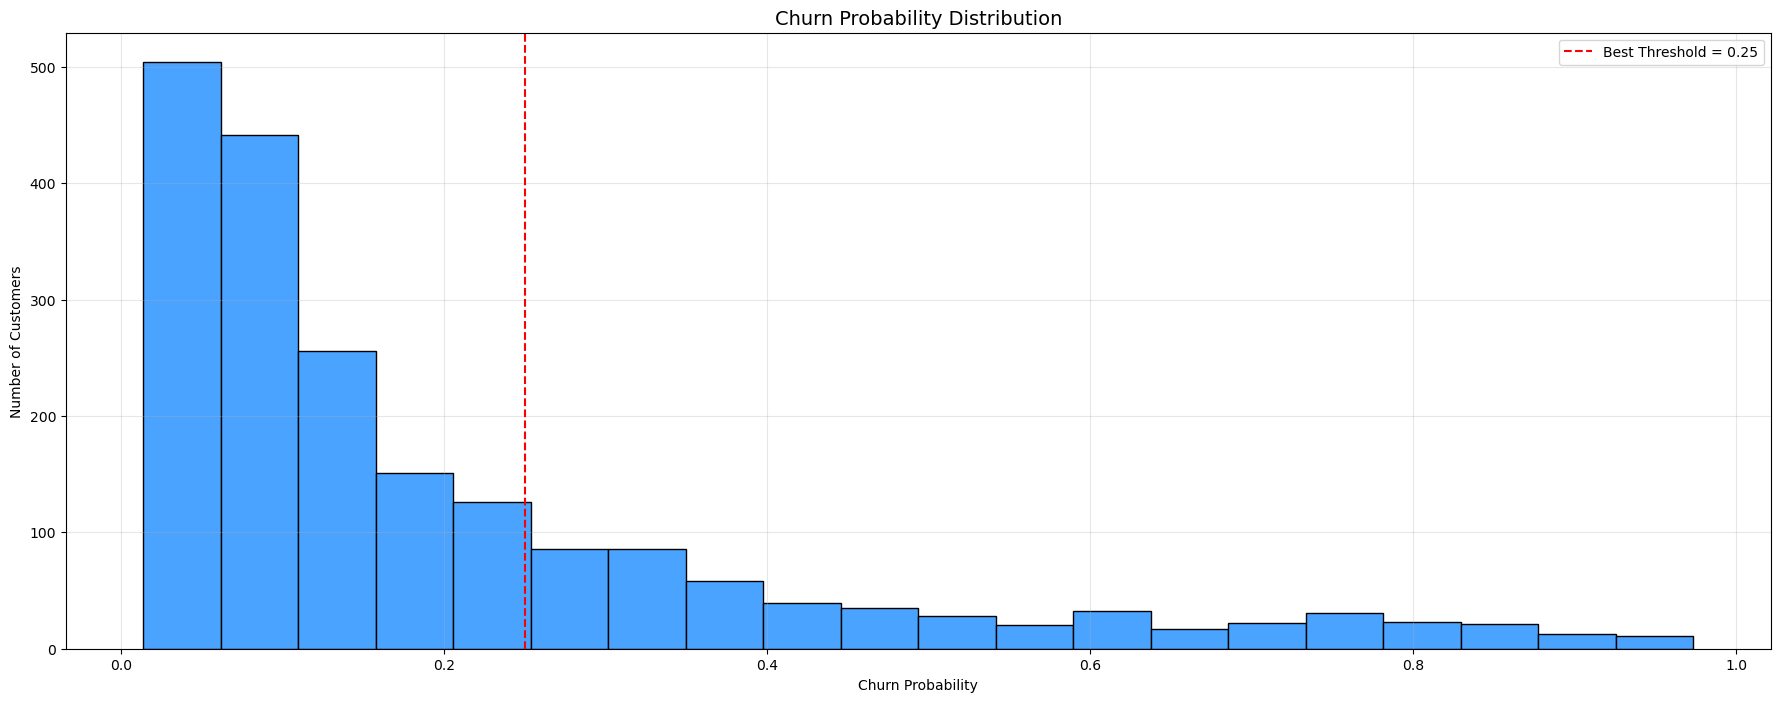

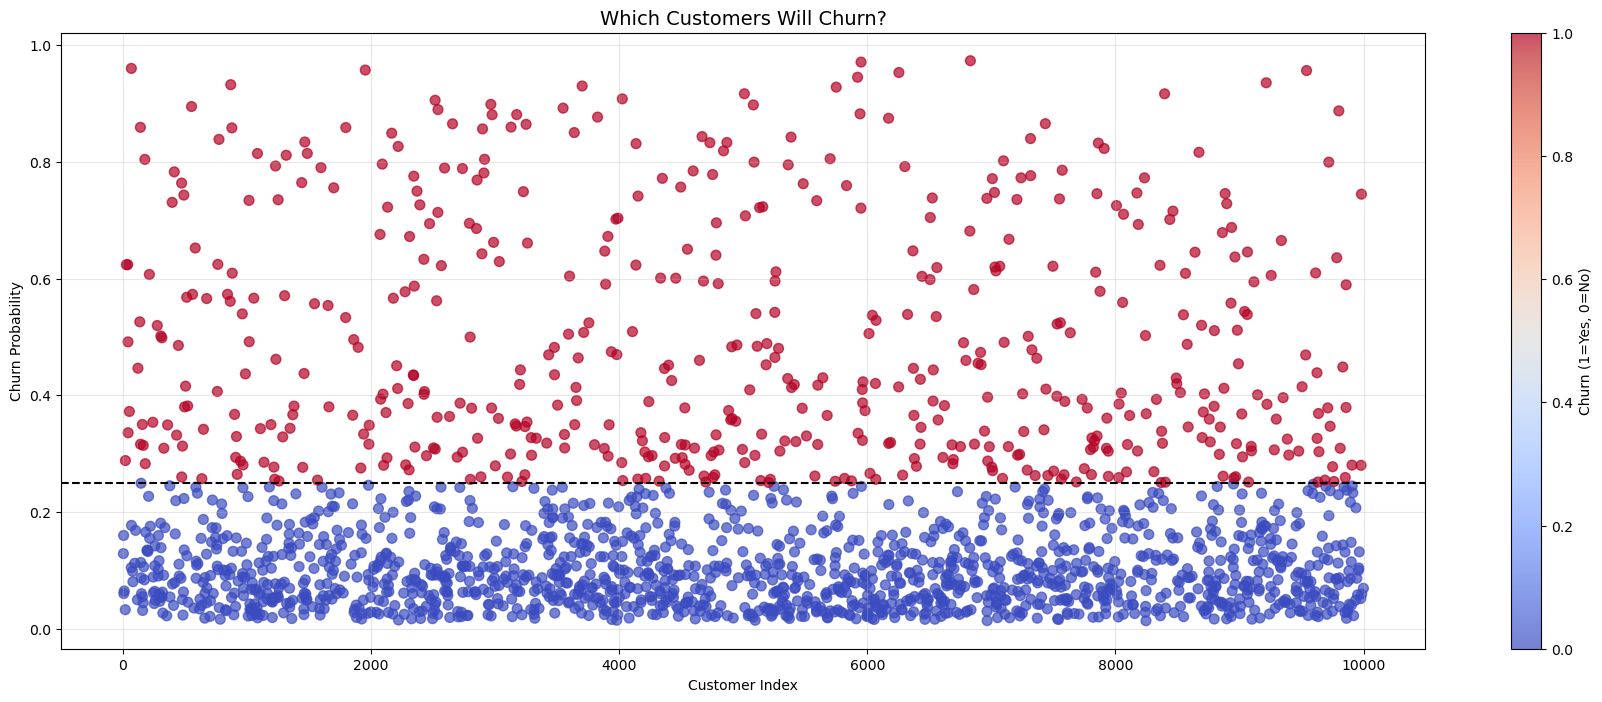

In [39]:
plt.figure(figsize=(22,8))
plt.hist(X_test_copy["Churn_Probability"], bins=20, color="#4aa3ff", edgecolor="black")
plt.axvline(best_t, color="red", linestyle="--", label=f"Best Threshold = {best_t:.2f}")
plt.title("Churn Probability Distribution", fontsize=14)
plt.xlabel("Churn Probability"); plt.ylabel("Number of Customers")
plt.legend(); plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(22,8))
plt.scatter(X_test_copy.index, X_test_copy["Churn_Probability"],
            c=X_test_copy["Predicted_Churn"], cmap="coolwarm", s=50, alpha=0.7)
plt.axhline(best_t, color="black", linestyle="--")
plt.title("Which Customers Will Churn?", fontsize=14)
plt.xlabel("Customer Index"); plt.ylabel("Churn Probability")
plt.colorbar(label="Churn (1=Yes, 0=No)")
plt.grid(alpha=0.3)
plt.show()


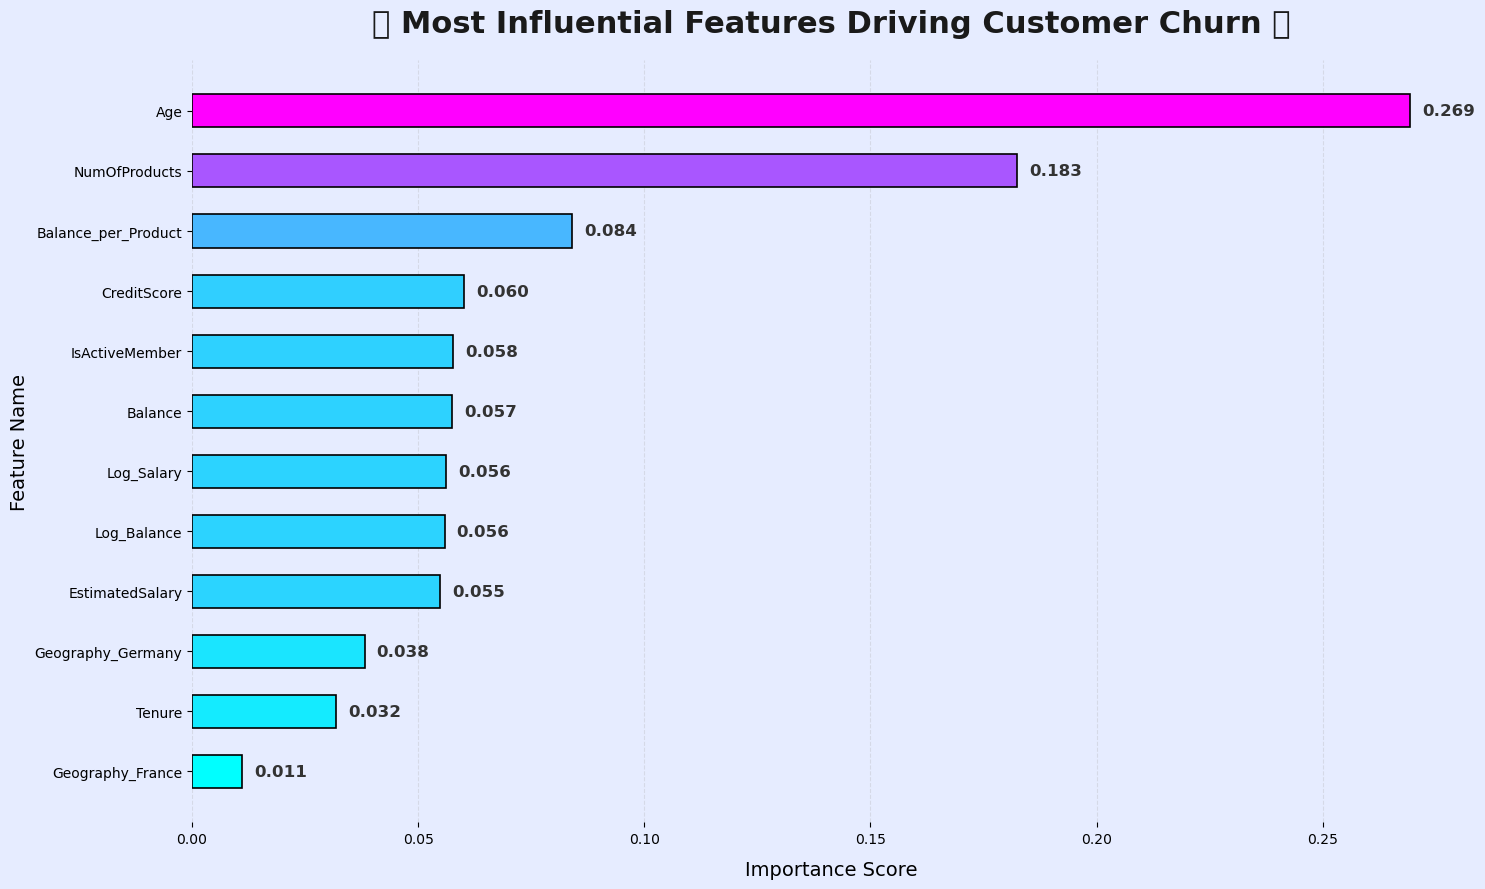

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ----------------------------
# Extract Feature Names
# ----------------------------
pre = best_model.named_steps["prep"]

num_names = numeric
try:
    ohe = pre.named_transformers_["cat"].named_steps["ohe"]
    cat_names = list(ohe.get_feature_names_out(categorical))
except:
    cat_names = categorical

feature_names = num_names + cat_names

# ----------------------------
# Feature Importances
# ----------------------------
try:
    model_obj = best_model.named_steps["model"]
    if hasattr(model_obj, "feature_importances_"):
        
        # prepare data
        importances = pd.Series(model_obj.feature_importances_, index=feature_names).sort_values()
        top = importances.tail(12)

        # ----------------------------
        # Stylish Look Setup
        # ----------------------------
        plt.figure(figsize=(15, 9))
        ax = plt.gca()

        # Gradient colormap
        cmap = mpl.cm.cool
        norm = mpl.colors.Normalize(vmin=top.min(), vmax=top.max())

        # Background style
        ax.set_facecolor("#f0f4ff")
        plt.gcf().patch.set_facecolor("#e6ecff")

        # Plot bars manually (rounded)
        for i, (feat, val) in enumerate(zip(top.index, top.values)):
            ax.barh(
                feat,
                val,
                color=cmap(norm(val)),
                edgecolor="black",
                linewidth=1.2,
                height=0.55
            )

        # Title and labels
        plt.title(
            "🔥 Most Influential Features Driving Customer Churn 🔥",
            fontsize=22, fontweight="bold", pad=20, color="#1a1a1a"
        )

        plt.xlabel("Importance Score", fontsize=14, labelpad=10)
        plt.ylabel("Feature Name", fontsize=14)

        # Annotate values on bars
        for bar in ax.patches:
            width = bar.get_width()
            y = bar.get_y() + bar.get_height() / 2
            ax.text(
                width + max(top) * 0.01,
                y,
                f"{width:.3f}",
                va='center',
                fontsize=12,
                fontweight='bold',
                color="#333"
            )

        # Grid + style adjustments
        ax.grid(axis="x", linestyle="--", alpha=0.3)
        ax.set_axisbelow(True)
        plt.box(False)

        plt.tight_layout()
        plt.show()

    else:
        print("Model does not provide feature_importances_.")
except Exception as e:
    print("Feature importance not available:", e)


In [41]:
churn_customers.to_csv("predicted_churn_customers.csv", index=False)
print("\nSaved churn customer file: predicted_churn_customers.csv")



Saved churn customer file: predicted_churn_customers.csv


In [42]:
!pip install xgboost
